In [243]:
from video_dataset import  VideoFrameDataset, ImglistToTensor
from torchvision import transforms
import torch
import matplotlib.pyplot as plt


In [254]:
from mpl_toolkits.axes_grid1 import ImageGrid
import os

def plot_video(rows, cols, frame_list, plot_width, plot_height, title: str):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        ax.imshow(im, cmap='gray')
    plt.show()

if __name__ == '__main__':
    videos_root = os.path.join(os.getcwd(), 'demo_dataset')
    annotation_file = os.path.join(videos_root, 'annotations.txt')

    preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = VideoFrameDataset(
        root_path=videos_root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=9,
        imagefile_template='img_{:05d}.jpg',
        transform=preprocess,
        test_mode=False
    )

    def denormalize(video_tensor):
        inverse_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        )
        return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()

    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=3,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )
    

Epoch: 0

Video Batch Tensor Size: torch.Size([3, 9, 3, 256, 256])

Video Batch Tensor Size: torch.Size([3, 9, 27])


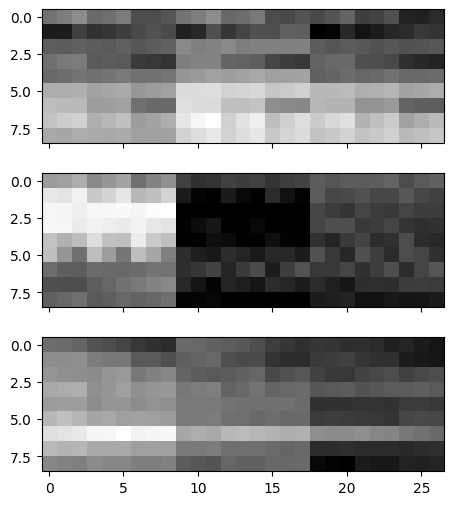

In [277]:
BATCH_SIZE = 3

for epoch in range(1):
        print("Epoch:", epoch)
        for video_batch, _ in dataloader:
            print("\nVideo Batch Tensor Size:", video_batch.size())
            # video_batch: (BATCH_SIZE, FRAMES, CHANNELS, HEIGHT, WIDTH)

            max_row_index = 256 - 3
            max_col_index = 256 - 3

            x = torch.randint(0, max_row_index, size=(BATCH_SIZE, 1))
            y = torch.randint(0, max_col_index, size=(BATCH_SIZE, 1))

            # Extract a 3x3 patch from the video batch
            patches = []
            for i in range(BATCH_SIZE):
                patch = video_batch[i, :, :, x[i]:x[i]+3, y[i]:y[i]+3]
                patches.append(patch)
            patches = torch.stack(patches, dim=0)
            
            em = patches.reshape(BATCH_SIZE, 9, 27)
            print("\nVideo Batch Tensor Size:", em.size())

            plot_video(3, 1, em*255, 6, 6, "embedding patch")

            # train
            break